# Training a generative model on MNIST

### Preliminaries

First, we have to import all the necessary packages and classes.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torch.autograd import Variable
from torch_two_sample import SmoothKNNStatistic, SmoothFRStatistic
from IPython.display import clear_output
from torchvision.utils import make_grid

We will need the following function later on to show the generated images.

In [2]:
# It is from the torchvision documentation on ``make_grid``.
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# We run on the GPU whenever possible.
cuda = torch.cuda.is_available()

# Let us fix the seed.
torch.manual_seed(0)
if cuda:
    torch.cuda.manual_seed(0)

### Step 1: Define the generative model

We will present a simple example of learning an implicit generative model on MNIST. As the base measure we will use a 10-dimensional Gaussian, and the following generative model:

In [3]:
noise_dim = 10  # The dimension of Q_0.
ambient_dim = 28 * 28  # The dimension of the generated samples.
generator = nn.Sequential(
    nn.Linear(noise_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 1024),
    nn.ReLU(),
    nn.Linear(1024, ambient_dim),
    nn.Tanh())  # Squash the output to [-1, 1].

if cuda:  # Move the model to the GPU if necessary.
    generator = generator.cuda()

### Step 2: Choose an optimizer

To optimize over the parameters of the generator we will use the Adam optimizer.

In [4]:
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)

### Step 3: Pick a loss function

As a loss function we will use the smoothed 1-NN loss with a batch size of 256.

In [5]:
batch_size = 256
# The 1-NN is the fastest, but the results seem to look better with FR.
loss_fn = SmoothKNNStatistic(
    batch_size, batch_size, cuda, 1, compute_t_stat=True)
# loss_fn = SmoothFRStatistic(
#     batch_size, batch_size, cuda, compute_t_stat=True)

### Step 4: Load the data

Next, let us load the MNIST dataset using torchvision.

In [6]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
dataset = MNIST('mnist_dir', transform=ToTensor(), download=True)

### Step 5: Train the model

We can then train the model for 100 epochs.

epoch 100, avg loss 1.31364666679


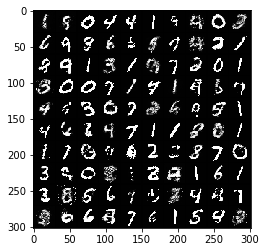

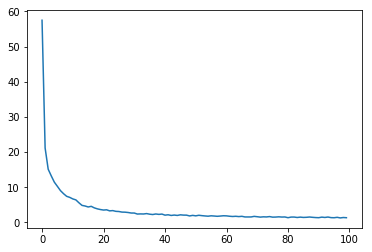

In [7]:
from torch.utils.data import DataLoader
# We will use tqdm to show a progress bar.
# If you don't have it, you can install it with ``pip install tqdm``.
from tqdm import tqdm_notebook as tqdm  
 
alphas=[0.1]  # The smoothing strength used.
n_epochs = 100  # Number of epochs.
avg_losses = []
for epoch in range(1, n_epochs + 1):  
  data_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True,
                           pin_memory=cuda, shuffle=True)
  # Note that we drop the last batch as each batch has to be of same size.
  # We create two tensors that will be filled with noise.
  # The first one is used for training, while the second one for visualization.
  if cuda:
    noise_tensor = torch.cuda.FloatTensor(batch_size, noise_dim)
    noise_plot = torch.cuda.FloatTensor(100, noise_dim)
  else:
    noise_tensor = torch.FloatTensor(batch_size, noise_dim)
    noise_plot = torch.FloatTensor(100, noise_dim)
  losses = []
  noise = Variable(noise_tensor)
  for batch, _ in tqdm(data_loader, leave=False):
    # We want one observation per row.
    # We moreover scale the images to [-1, 1] as we use a Tanh layer.
    batch = 2 * batch.view(batch_size, -1) - 1
    if cuda:
      batch = batch.cuda()
    noise_tensor.normal_()  # Sample the noise.
    optimizer.zero_grad()
    loss = loss_fn(Variable(batch), generator(noise), alphas=alphas)
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

  # Now that the epochs has finished, we will draw samples from the model.
  clear_output()
  avg_loss = sum(losses) / len(losses)
  print('epoch {0:>2d}, avg loss {1}'.format(epoch, avg_loss))
  avg_losses.append(avg_loss)
  # We will draw 100 images and show them on a 10x10 grid.
  noise_plot.normal_()
  samples = generator(Variable(noise_plot)).view(-1, 1, 28, 28).cpu().data
  show(make_grid(samples, nrow=10))
  plt.show()
  plt.plot(avg_losses)
  plt.show()